In [ ]:
!pip -q install scikit-learn

import os, torch, torchaudio
print("CUDA available:", torch.cuda.is_available())

!ls -R /kaggle/input/audeter-subset-3500each-all/audeter_subset_3500each_ALL | head -n 80
!ls /kaggle/input/ready-to-input-for-training/combined_folder/real | head -n 20
!ls /kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real | head -n 20


In [ ]:
import os, math, time, json, pathlib, random
from typing import Tuple, Dict
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

SAMPLE_RATE = 16000
DURATION_S  = 1.0   # crop/pad to 1 second
N_MELS      = 128
BATCH_SIZE  = 32
EPOCHS      = 30

# Telephony Aug activation (for baseline Task A = False)
USE_AUG = False

# cobination of real datasets from asvspoof2021 and in the wild
REAL_MAIN_CAP  = 60000   
REAL_WILD_CAP  = 20000  

FAKE_ROOT       = "/kaggle/input/audeter-subset-3500each-all/audeter_subset_3500each_ALL"
REAL_MAIN_ROOT  = "/kaggle/input/ready-to-input-for-training/combined_folder/real"
REAL_WILD_ROOT  = "/kaggle/input/in-the-wild-audio-deepfake/release_in_the_wild/real"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset (torchaudio-only; no librosa)

In [ ]:
class TelephonyAug:

    def __init__(self, sample_rate=16000, nb_sr=8000, noise_snr_db=(10, 25)):
        self.sr = sample_rate
        self.nb_sr = nb_sr
        self.noise_snr_db = noise_snr_db

    def _add_noise(self, x: torch.Tensor):
        snr_db = float(np.random.uniform(*self.noise_snr_db))
        p_sig = x.pow(2).mean().item() + 1e-12
        p_noise = p_sig / (10 ** (snr_db / 10))
        noise = torch.randn_like(x) * math.sqrt(p_noise)
        return x + noise

    def __call__(self, wav: torch.Tensor):
        # downsample to narrowband-ish, compand, upsample, bandlimit, add noiseto datasets
        y = torchaudio.functional.resample(wav, self.sr, self.nb_sr)
        y = torch.tanh(1.5 * y)
        y = torchaudio.functional.resample(y, self.nb_sr, self.sr)
        y = torchaudio.functional.highpass_biquad(y, self.sr, 300)
        y = torchaudio.functional.lowpass_biquad(y, self.sr, 3400)
        y = self._add_noise(y)
        return y


class DeepfakeAudioDatasetTaskA(Dataset):
    """
    Task A dataset:
    -Fake: all clips from AUDETER (~80k), label=1
    -Real: 60k clips from combined_folder/real, label=0
    -Real: 20k clips from in-the-wild/real, label=0
    Total: ~80k fake vs ~80k real (balanced datasets).
    """
    def __init__(
        self,
        fake_root: str,
        real_root_main: str,
        real_root_wild: str,
        real_main_cap: int = 60000,
        real_wild_cap: int = 20000,
        sample_rate: int = 16000,
        duration: float = 1.0,
        n_mels: int = 128,
        use_aug: bool = False,
        extensions=(".wav", ".flac", ".mp3")
    ):
        self.sample_rate = sample_rate
        self.duration = duration
        self.max_len = int(sample_rate * duration)
        self.n_mels = n_mels
        self.use_aug = use_aug

        fake_paths = []
        if os.path.isdir(fake_root):
            for root, dirs, files in os.walk(fake_root):
                for f in files:
                    if f.lower().endswith(extensions):
                        fake_paths.append(os.path.join(root, f))
        fake_labels = [1] * len(fake_paths)

        real_paths_main = []
        if os.path.isdir(real_root_main):
            for f in os.listdir(real_root_main):
                p = os.path.join(real_root_main, f)
                if os.path.isfile(p) and f.lower().endswith(extensions):
                    real_paths_main.append(p)
        random.shuffle(real_paths_main)
        real_paths_main = real_paths_main[:real_main_cap]

        real_paths_wild = []
        if os.path.isdir(real_root_wild):
            for f in os.listdir(real_root_wild):
                p = os.path.join(real_root_wild, f)
                if os.path.isfile(p) and f.lower().endswith(extensions):
                    real_paths_wild.append(p)
        random.shuffle(real_paths_wild)
        real_paths_wild = real_paths_wild[:real_wild_cap]

        real_paths = real_paths_main + real_paths_wild
        real_labels = [0] * len(real_paths)

        self.audio_paths = fake_paths + real_paths
        self.labels = fake_labels + real_labels

        print(f"[TaskA Dataset] fake={len(fake_paths)} real={len(real_paths)} total={len(self.audio_paths)}")

        # Feature transforms: MelSpectrogram + dB
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=1024,
            hop_length=256,
            power=2.0
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB(stype="power")

        self.tel_aug = TelephonyAug(sample_rate=self.sample_rate) if self.use_aug else None

    def __len__(self):
        return len(self.audio_paths)

    def _load_resample_mono(self, path: str) -> torch.Tensor:
        wav, sr = torchaudio.load(path)  
        wav = wav.mean(dim=0)  
        if sr != self.sample_rate:
            wav = torchaudio.functional.resample(wav, sr, self.sample_rate)

        # use pad or trim to fixed length
        if wav.shape[0] < self.max_len:
            wav = F.pad(wav, (0, self.max_len - wav.shape[0]))
        else:
            wav = wav[: self.max_len]
        return wav

    def __getitem__(self, idx: int):
        path = self.audio_paths[idx]
        label = self.labels[idx]

        wav = self._load_resample_mono(path)  
        if self.tel_aug is not None:
            wav = self.tel_aug(wav)

        wav_2d = wav.unsqueeze(0)  

        mel = self.melspec(wav_2d)  
        mel_db = self.to_db(mel)

        return wav_2d.float(), mel_db.float(), torch.tensor(label).long()


Here we:

define TelephonyAug,

define DeepfakeAudioDatasetTaskA that:

loads all fake from AUDETER,

loads 60k real from combined_folder/real,

loads 20k real from in-the-wild/real,

does waveform trimming/padding,

makes Mel-spectrogram.

In [ ]:
class SpecRNet(nn.Module):

    # CNN over Mel-spectrogram - 128-D embedding
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, 128)

    def forward(self, x):
        x = self.features(x)    
        x = x.view(x.size(0), -1) 
        return self.fc(x)       


class RawGATST(nn.Module):

    # Lightweight 1D conv stack on raw waveform - 128-D embedding
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 128)

    def forward(self, x):
        x = self.conv(x)              
        x = self.pool(x).squeeze(-1)  
        return self.fc(x)             


class FusionNet(nn.Module):

    # Fuse raw branch + mel branch 
    def __init__(self):
        super().__init__()
        self.spec_model = SpecRNet()
        self.raw_model  = RawGATST()
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, raw_wave, mel_spec):
        raw_feat  = self.raw_model(raw_wave)    
        spec_feat = self.spec_model(mel_spec)   
        fused = torch.cat((raw_feat, spec_feat), dim=1)  
        return self.classifier(fused)           


1.	SpecRNet → CNN applied on Mel-spectrograms (2D input).
(mel_spec): a time–frequency representation, closer to how humans perceive sound, useful to detect spectral artifacts in fakes
2.	RawGAT-ST → CNN applied on raw waveforms (1D input).
(raw_wave): the direct audio signal, useful to capture fine low-level details (noise, glitches).
3.	Feature Fusion → Concatenation of both feature vectors.
---->processes two views of the same audio.


models (SpecRNet, RawGATST, FusionNet)

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    for raw, mel, labels in loader:
        raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)
        outputs = model(raw, mel)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / max(1, total), correct / max(1, total)


def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters())


def file_size_mb(path: str) -> float:
    p = pathlib.Path(path)
    return p.stat().st_size / (1024 * 1024)


def benchmark_inference(model, loader, device=torch.device("cpu")):
    model = model.to(device).eval()
    start = time.time()
    n = 0
    with torch.no_grad():
        for raw, mel, _ in loader:
            raw, mel = raw.to(device), mel.to(device)
            _ = model(raw, mel)
            n += raw.size(0)
    dt = time.time() - start
    return {
        "batches": len(loader),
        "samples": n,
        "total_sec": dt,
        "sec_per_batch": dt / max(1, len(loader)),
        "ms_per_sample": 1000.0 * dt / max(1, n),
    }


def eval_confusion_auc_eer(model, loader, device=torch.device("cpu")):
    model = model.to(device).eval()
    ys, ps = [], []
    with torch.no_grad():
        for raw, mel, y in loader:
            raw, mel = raw.to(device), mel.to(device)
            prob_fake = F.softmax(model(raw, mel), dim=1)[:, 1].cpu().numpy()
            ys.append(y.numpy()); ps.append(prob_fake)
    y_true = np.concatenate(ys)
    y_score = np.concatenate(ps)

    # confusion matrix
    y_pred = (y_score >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # roc-auc
    try:
        auc = roc_auc_score(y_true, y_score)
    except ValueError:
        auc = float("nan")

    # eer
    fpr, tpr, th = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    eer_thr = th[idx]
    return {
        "confusion_matrix": cm.tolist(),
        "roc_auc": float(auc),
        "eer": float(eer),
        "eer_threshold": float(eer_thr)
    }


from torch.quantization import quantize_dynamic
def quantize_linear_layers(model: nn.Module) -> nn.Module:
    q_model = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
    return q_model


def export_onnx(model, out_path="fusionnet_taskA.onnx", raw_len=16000, n_mels=128, t_frames=64):

    model_cpu = model.to("cpu").eval()
    dummy_raw = torch.randn(1, 1, raw_len)
    dummy_mel = torch.randn(1, 1, n_mels, t_frames)
    torch.onnx.export(
        model_cpu, (dummy_raw, dummy_mel), out_path,
        input_names=["raw", "mel"],
        output_names=["logits"],
        opset_version=17,
        dynamic_axes={
            "raw": {2: "raw_len"},
            "mel": {2: "n_mels", 3: "time"},
            "logits": {1: "num_classes"},
        },
    )
    print("Exported:", out_path)


def post_training_report(model, val_loader, test_loader):
    torch.save(model.state_dict(), "fusionnet_taskA_fp32.pth")
    fp32_mb = file_size_mb("fusionnet_taskA_fp32.pth")

    cpu_stats = benchmark_inference(model, val_loader, device=torch.device("cpu"))
    metrics   = eval_confusion_auc_eer(model, test_loader, device=torch.device("cpu"))

    q_model = quantize_linear_layers(model)
    torch.save(q_model.state_dict(), "fusionnet_taskA_int8_linear.pth")
    int8_mb = file_size_mb("fusionnet_taskA_int8_linear.pth")

    q_cpu_stats = benchmark_inference(q_model, val_loader, device=torch.device("cpu"))
    q_metrics   = eval_confusion_auc_eer(q_model, test_loader, device=torch.device("cpu"))

    report = {
        "model_params": int(count_params(model)),
        "files": {
            "fp32_path": "fusionnet_taskA_fp32.pth", "fp32_mb": round(fp32_mb, 3),
            "int8_path": "fusionnet_taskA_int8_linear.pth", "int8_mb": round(int8_mb, 3),
        },
        "cpu_benchmark_fp32": cpu_stats,
        "cpu_benchmark_int8": q_cpu_stats,
        "metrics_fp32": metrics,
        "metrics_int8": q_metrics,
    }
    print(json.dumps(report, indent=2))
    return report


In [ ]:
taskA_dataset = DeepfakeAudioDatasetTaskA(
    fake_root=FAKE_ROOT,
    real_root_main=REAL_MAIN_ROOT,
    real_root_wild=REAL_WILD_ROOT,
    real_main_cap=REAL_MAIN_CAP,
    real_wild_cap=REAL_WILD_CAP,
    sample_rate=SAMPLE_RATE,
    duration=DURATION_S,
    n_mels=N_MELS,
    use_aug=USE_AUG
)

# split 60% train / 20% val / 20% test
indices = list(range(len(taskA_dataset)))
labels_for_strat = [taskA_dataset[i][2].item() for i in indices]

train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
    stratify=labels_for_strat
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=SEED,
    shuffle=True,
    stratify=[labels_for_strat[i] for i in temp_idx]
)

train_set_A = Subset(taskA_dataset, train_idx)
val_set_A   = Subset(taskA_dataset, val_idx)
test_set_A  = Subset(taskA_dataset, test_idx)

train_loader_A = DataLoader(
    train_set_A, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader_A = DataLoader(
    val_set_A, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)
test_loader_A = DataLoader(
    test_set_A, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

print("Task A split sizes:",
      len(train_set_A), len(val_set_A), len(test_set_A))


In [ ]:
import random as pyrand

class StrongAug:
    # Stronger audio augmentation pipeline intended for Task B@telephony robustness.
    def __init__(self, sr=16000):
        self.sr = sr
        self.tel = TelephonyAug(sample_rate=sr)

    def __call__(self, wav):
        x = wav
        if pyrand.random() < 0.7:
            x = self.tel(x)
        try:
            if pyrand.random() < 0.5:
                rate = pyrand.uniform(0.92, 1.08)
                x, _ = torchaudio.sox_effects.apply_effects_tensor(
                    x.unsqueeze(0), self.sr,
                    [["speed", f"{rate}"], ["rate", str(self.sr)]]
                )
                x = x.squeeze(0)
        except Exception:
            pass
        return x

In [ ]:
model = FusionNet().to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2
)

loss_fn = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())

PATIENCE    = 5
CLIP_NORM   = 1.0
best_val_loss = float("inf")
best_path_A = "fusionnet_taskA_best.pth"
no_improve  = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    run_loss = 0.0
    run_correct = 0
    seen = 0

    for raw, mel, labels in train_loader_A:
        raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
            out = model(raw, mel)
            loss = loss_fn(out, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()

        run_loss    += loss.item() * labels.size(0)
        run_correct += (out.argmax(1) == labels).sum().item()
        seen        += labels.size(0)

    train_loss = run_loss / seen
    train_acc  = run_correct / seen

    val_loss, val_acc = evaluate(model, val_loader_A, device)
    scheduler.step(val_loss)

    print(f"[TaskA] Epoch {epoch:02d} | "
          f"train {train_loss:.4f}/{train_acc:.4f} | "
          f"val {val_loss:.4f}/{val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), best_path_A)
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping on Task A.")
            break

print("Best checkpoint saved to:", best_path_A)


Training on ~160K audio segments per epoch is heavy on Kaggle. 
-we interrupted long loops (KeyboardInterrupt) once validation accuracy was already very high, then saved that checkpoint as our Task A model

In [ ]:
model = FusionNet().to(device)
model.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location=device))
model.eval()

test_loss_A, test_acc_A = evaluate(model, test_loader_A, device)
print(f"[TaskA TEST] loss={test_loss_A:.4f}  acc={test_acc_A:.4f}")

misclassified = []
correct_pred  = []

with torch.no_grad():
    for raw_batch, mel_batch, labels_batch in test_loader_A:
        raw_batch, mel_batch, labels_batch = (
            raw_batch.to(device),
            mel_batch.to(device),
            labels_batch.to(device),
        )
        outputs = model(raw_batch, mel_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(len(labels_batch)):
            true_label = labels_batch[i].item()
            pred_label = preds[i].item()
            confidence = float(probs[i][pred_label].item())
            entry = {
                "true": "FAKE" if true_label == 1 else "REAL",
                "pred": "FAKE" if pred_label == 1 else "REAL",
                "confidence": confidence
            }
            if true_label != pred_label:
                misclassified.append(entry)
            else:
                correct_pred.append(entry)

print(f"Total Correct: {len(correct_pred)}")
print(f"Total Misclassified: {len(misclassified)}")

print("\nSample Misclassifications (up to 10):")
for item in misclassified[:10]:
    print(f"True={item['true']} | Pred={item['pred']} | Conf={item['confidence']*100:.2f}%")


In [ ]:
QUICK_MODE = False
MAX_BATCHES = 50  #only used if QUICK MODE = TRUE

def collect_scores_fast(m, loader, device, quick=False, max_batches=50):
    m = m.to(device).eval()
    ys, ps = [], []
    with torch.inference_mode():
        for bi, (raw, mel, y) in enumerate(loader):
            raw = raw.to(device, non_blocking=True)
            mel = mel.to(device, non_blocking=True)
            logits = m(raw, mel)
            prob_fake = torch.softmax(logits, dim=1)[:, 1]
            ys.append(y.cpu().numpy())
            ps.append(prob_fake.detach().cpu().numpy())
            if quick and (bi + 1) >= max_batches:
                break
    return np.concatenate(ys), np.concatenate(ps)

y_true, y_score = collect_scores_fast(
    model, test_loader_A, device, quick=QUICK_MODE, max_batches=MAX_BATCHES
)

auc = roc_auc_score(y_true, y_score)
fpr, tpr, thr_all = roc_curve(y_true, y_score)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = 0.5 * (fpr[eer_idx] + fnr[eer_idx])
eer_thr = float(thr_all[eer_idx])

print(f"AUC = {auc:.4f}")
print(f"EER = {eer:.4f} at threshold = {eer_thr:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task A model)")
plt.legend()
plt.show()

# confusion Matrix @ EER threshold
y_pred = (y_score >= eer_thr).astype(int)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix @ EER threshold [rows: TRUE (REAL,FAKE), cols: PRED (REAL,FAKE)]")
print(cm)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, labels=[0,1], display_labels=["REAL","FAKE"]
)
plt.title(f"Confusion Matrix @ thr={eer_thr:.2f} (Task A)")
plt.show()


In [ ]:
model.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location=device))
model.eval()

report_taskA = post_training_report(model, val_loader_A, test_loader_A)

with open("taskA_report.json", "w") as f:
    json.dump(report_taskA, f, indent=2)

!ls -lh /kaggle/working | sed -n '1,200p'


In [ ]:
def collect_scores_fast(m, loader, device, quick=False, max_batches=999999):
    m = m.to(device).eval()
    ys, ps = [], []
    with torch.inference_mode():
        for bi, (raw, mel, y) in enumerate(loader):
            raw = raw.to(device, non_blocking=True)
            mel = mel.to(device, non_blocking=True)
            p = torch.softmax(m(raw, mel), dim=1)[:, 1]
            ys.append(y.cpu().numpy()); ps.append(p.detach().cpu().numpy())
            if quick and (bi+1) >= max_batches: break
    return np.concatenate(ys), np.concatenate(ps)

def save_roc_cm_png(ckpt_path, test_loader, tag):
    m = FusionNet().to(device)
    m.load_state_dict(torch.load(ckpt_path, map_location=device))
    m.eval()

    y_true, y_score = collect_scores_fast(m, test_loader, device)
    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, thr_all = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    thr = float(thr_all[idx])
    
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {tag}")
    plt.legend()
    plt.savefig(f"roc_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["REAL","FAKE"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {tag} @ thr={thr:.2f}")
    plt.savefig(f"cm_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    print(f"[{tag}] AUC={auc:.4f} | EER={eer:.4f} | thr={thr:.4f} -> saved roc_{tag}.png, cm_{tag}.png")

save_roc_cm_png("fusionnet_taskA_best.pth", test_loader_A, tag="taskA")

!ls -lh /kaggle/working | egrep "roc_|cm_"


In [ ]:
def export_onnx_fixed(model, val_loader, out_path="fusionnet_taskA.onnx", raw_len=16000):
    model_cpu = model.to("cpu").eval()

    try:
        _, mel_b, _ = next(iter(val_loader))
        _, _, n_mels, t_frames = mel_b.shape
        n_mels = int(n_mels)
        t_frames = int(t_frames)
    except StopIteration:
        n_mels, t_frames = 128, 64

    dummy_raw = torch.randn(1, 1, raw_len)
    dummy_mel = torch.randn(1, 1, n_mels, t_frames)

    torch.onnx.export(
        model_cpu,
        (dummy_raw, dummy_mel),
        out_path,
        input_names=["raw","mel"],
        output_names=["logits"],
        opset_version=17,
        do_constant_folding=True
    )
    print(f"Exported ONNX -> {out_path} | mel=({n_mels},{t_frames}) raw={raw_len}")


model_cpu = FusionNet().to("cpu")
model_cpu.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location="cpu"))
export_onnx_fixed(model_cpu, val_loader_A, out_path="fusionnet_taskA.onnx", raw_len=16000)

!ls -lh /kaggle/working/fusionnet_taskA.onnx


# Start TaskB here:

In [ ]:
# We reuse the same DeepfakeAudioDatasetTaskA class, but with use_aug=True
# so TelephonyAug is applied

USE_AUG_TASKB = True

taskB_dataset = DeepfakeAudioDatasetTaskA(
    fake_root=FAKE_ROOT,
    real_root_main=REAL_MAIN_ROOT,
    real_root_wild=REAL_WILD_ROOT,
    real_main_cap=REAL_MAIN_CAP,
    real_wild_cap=REAL_WILD_CAP,
    sample_rate=SAMPLE_RATE,
    duration=DURATION_S,
    n_mels=N_MELS,
    use_aug=USE_AUG_TASKB
)

indices_B = list(range(len(taskB_dataset)))
labels_B  = [taskB_dataset.labels[i] for i in indices_B]

from sklearn.model_selection import train_test_split

train_idx_B, temp_idx_B = train_test_split(
    indices_B,
    test_size=0.4,
    random_state=SEED,
    shuffle=True,
    stratify=labels_B
)

val_idx_B, test_idx_B = train_test_split(
    temp_idx_B,
    test_size=0.5,
    random_state=SEED,
    shuffle=True,
    stratify=[labels_B[i] for i in temp_idx_B]
)

from torch.utils.data import Subset, DataLoader

train_set_B = Subset(taskB_dataset, train_idx_B)
val_set_B   = Subset(taskB_dataset, val_idx_B)
test_set_B  = Subset(taskB_dataset, test_idx_B)

train_loader_B = DataLoader(train_set_B, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_B   = DataLoader(val_set_B,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_B  = DataLoader(test_set_B,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Task B split sizes:", len(train_set_B), len(val_set_B), len(test_set_B))


In [ ]:
# Load Task A model
model_B = FusionNet().to(device)
model_B.load_state_dict(torch.load("fusionnet_taskA_best.pth", map_location=device))
model_B.train()

prev_weights = {}
for name, p in model_B.named_parameters():
    prev_weights[name] = p.detach().clone()

print("Loaded Task A weights into model_B and snapshotted prev_weights.")


In [ ]:
# freeze backbone to protect learned audio features
for p in model_B.spec_model.parameters():
    p.requires_grad = False
for p in model_B.raw_model.parameters():
    p.requires_grad = False
# trainable classifiers
for p in model_B.classifier.parameters():
    p.requires_grad = True


In [ ]:
def continual_train_taskB(
    model,
    train_loader_new, #telephony augmented data
    val_loader_old, #clean data that is trained on Task A
    prev_weights_dict,
    device,
    epochs=8,
    lr=5e-4,
    reg_lambda=1e-3,
    clip_norm=1.0,
    patience=3,
    save_path="fusionnet_taskB_best.pth"
):


    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr,
        weight_decay=1e-4
    )
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=1
    )
    loss_fn = torch.nn.CrossEntropyLoss()

    scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())

    best_val_loss = float("inf")
    no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        run_correct = 0
        seen = 0

        for raw, mel, labels in train_loader_new:
            raw, mel, labels = raw.to(device), mel.to(device), labels.to(device)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=torch.cuda.is_available()):
                out = model(raw, mel)
                base_loss = loss_fn(out, labels)

                # regularization term: don't drift too far from Task A weights
                reg_loss = 0.0
                for (name, p) in model.named_parameters():
                    if p.requires_grad and name in prev_weights_dict:
                        reg_loss = reg_loss + (p - prev_weights_dict[name].to(device)).pow(2).mean()

                loss = base_loss + reg_lambda * reg_loss

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            scaler.step(opt)
            scaler.update()

            run_loss += loss.item() * labels.size(0)
            run_correct += (out.argmax(1) == labels).sum().item()
            seen += labels.size(0)

        train_loss = run_loss / seen
        train_acc  = run_correct / seen

        # validate on OLD domain (Task A val set) to measure forgetting
        val_loss, val_acc = evaluate(model, val_loader_old, device)

        sched.step(val_loss)

        print(f"[TaskB] Epoch {epoch:02d} | train {train_loss:.4f}/{train_acc:.4f} "
              f"| old_val {val_loss:.4f}/{val_acc:.4f}")

        # early stopping on OLD domain val loss -> we try not to destroy Task A
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), save_path)
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping Task B.")
                break

    print("Best continual checkpoint saved to:", save_path)


In [ ]:
# fine-tune model_B on Task B data for continual learning
continual_train_taskB(
    model=model_B,
    train_loader_new=train_loader_B,
    val_loader_old=val_loader_A,        
    prev_weights_dict=prev_weights,
    device=device,
    epochs=8,
    lr=5e-4,
    reg_lambda=1e-3,
    save_path="fusionnet_taskB_best.pth"
)


In [ ]:
modelB_eval = FusionNet().to(device)
modelB_eval.load_state_dict(torch.load("fusionnet_taskB_best.pth", map_location=device))
modelB_eval.eval()

loss_B_new, acc_B_new = evaluate(modelB_eval, test_loader_B, device)
print(f"[TaskB model on TaskB audio] loss={loss_B_new:.4f} acc={acc_B_new:.4f}")

loss_B_old, acc_B_old = evaluate(modelB_eval, test_loader_A, device)
print(f"[TaskB model on TaskA audio] loss={loss_B_old:.4f} acc={acc_B_old:.4f}")


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def collect_scores_for_loader(model, loader, device):
    model = model.to(device).eval()
    ys, ps = [], []
    with torch.no_grad():
        for raw, mel, y in loader:
            raw = raw.to(device, non_blocking=True)
            mel = mel.to(device, non_blocking=True)

            logits = model(raw, mel)
            prob_fake = torch.softmax(logits, dim=1)[:, 1]  

            ys.append(y.cpu().numpy())
            ps.append(prob_fake.detach().cpu().numpy())

    y_true = np.concatenate(ys)
    y_score = np.concatenate(ps)
    return y_true, y_score

def save_taskB_roc_cm(taskB_ckpt_path, test_loader_new, tag="taskB"):
    # load continual model
    m = FusionNet().to(device)
    m.load_state_dict(torch.load(taskB_ckpt_path, map_location=device))
    m.eval()

    y_true, y_score = collect_scores_for_loader(m, test_loader_new, device)

    auc = roc_auc_score(y_true, y_score)

    fpr, tpr, thr_all = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    thr = float(thr_all[idx])

    print(f"[{tag}] AUC={auc:.4f} | EER={eer:.4f} | thr={thr:.4f}")

    # ROC 
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {tag} (continual model)")
    plt.legend()
    plt.savefig(f"roc_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    # Confusion matrix @ EER threshold
    y_pred = (y_score >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    disp = ConfusionMatrixDisplay(cm, display_labels=["REAL","FAKE"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {tag} @ thr={thr:.2f}")
    plt.savefig(f"cm_{tag}.png", dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved roc_{tag}.png and cm_{tag}.png")
    print("Confusion matrix:\n", cm)

save_taskB_roc_cm(
    taskB_ckpt_path="fusionnet_taskB_best.pth",
    test_loader_new=test_loader_B,
    tag="taskB"
)

!ls -lh /kaggle/working | egrep "roc_|cm_"


In [ ]:
import torch
import torchaudio

def export_taskB_to_onnx(taskB_ckpt_path, val_loader_for_shape, out_path="fusionnet_taskB.onnx", raw_len=16000):
    model_cpu = FusionNet().to("cpu")
    model_cpu.load_state_dict(torch.load(taskB_ckpt_path, map_location="cpu"))
    model_cpu.eval()

    try:
        _, mel_b, _ = next(iter(val_loader_for_shape))
        _, _, n_mels, t_frames = mel_b.shape
        n_mels = int(n_mels)
        t_frames = int(t_frames)
    except StopIteration:
        n_mels, t_frames = 128, 64

    # dummy inputs to trace ONNX
    dummy_raw = torch.randn(1, 1, raw_len)
    dummy_mel = torch.randn(1, 1, n_mels, t_frames)

    torch.onnx.export(
        model_cpu,
        (dummy_raw, dummy_mel),
        out_path,
        input_names=["raw","mel"],
        output_names=["logits"],
        opset_version=17,
        do_constant_folding=True
    )

    print(f"Exported ONNX -> {out_path} | mel=({n_mels},{t_frames}) raw={raw_len}")

#export the Task B model using Task B val loader
export_taskB_to_onnx(
    taskB_ckpt_path="fusionnet_taskB_best.pth",
    val_loader_for_shape=val_loader_B,
    out_path="fusionnet_taskB.onnx",
    raw_len=16000
)

!ls -lh /kaggle/working/fusionnet_taskB.onnx


# TaskA vs TaskB ROC + Confusion Matrices

TaskA vs TaskB ROC + Confusion Matrices (use Telephony-domain eval set (Task B test_loader_B))

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def collect_scores(model, loader, device):
    model = model.to(device).eval()
    all_labels = []
    all_scores_fake = []  
    for raw, mel, y in loader:
        raw = raw.to(device, non_blocking=True)
        mel = mel.to(device, non_blocking=True)
        logits = model(raw, mel)          
        probs = F.softmax(logits, dim=1)  
        fake_scores = probs[:, 1].detach().cpu().numpy()  
        all_scores_fake.append(fake_scores)
        all_labels.append(y.numpy())
    all_labels = np.concatenate(all_labels)
    all_scores_fake = np.concatenate(all_scores_fake)
    return all_labels, all_scores_fake

#load both models
taskA_ckpt = "/kaggle/input/task-bestpth/fusionnet_taskA_best.pth" 
taskB_ckpt = "/kaggle/input/task-bestpth/fusionnet_taskB_best.pth"   

modelA = FusionNet()
modelA.load_state_dict(torch.load(taskA_ckpt, map_location=device))
modelA.eval()

modelB = FusionNet()
modelB.load_state_dict(torch.load(taskB_ckpt, map_location=device))
modelB.eval()

# pick which on to compare on:
# compare on clean domain
#loader_eval = test_loader_A
#title_domain = "Clean-domain eval set (Task A test_loader_A)"

# compare on telephony/robust domain
loader_eval = test_loader_B
title_domain = "Telephony-domain eval set (Task B test_loader_B)"

y_true_A, y_score_A = collect_scores(modelA, loader_eval, device)
y_true_B, y_score_B = collect_scores(modelB, loader_eval, device) # use same eval loader

# roc auc graph
fpr_A, tpr_A, _ = roc_curve(y_true_A, y_score_A)
auc_A = roc_auc_score(y_true_A, y_score_A)

fpr_B, tpr_B, _ = roc_curve(y_true_B, y_score_B)
auc_B = roc_auc_score(y_true_B, y_score_B)

plt.figure(figsize=(6,5))
plt.plot(fpr_A, tpr_A, label=f"Task A model (AUC={auc_A:.3f})")
plt.plot(fpr_B, tpr_B, label=f"Task B model (AUC={auc_B:.3f})")
plt.plot([0,1],[0,1],'--', color='gray', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC — Task A vs Task B\n{title_domain}")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"[ROC summary] On {title_domain}:")
print(f" Task A AUC = {auc_A:.4f}")
print(f" Task B AUC = {auc_B:.4f}")

# confusion matrix
thr_A = 0.1203
thr_B = 0.5664

y_pred_A = (y_score_A >= thr_A).astype(int) 
y_pred_B = (y_score_B >= thr_B).astype(int)

cm_A = confusion_matrix(y_true_A, y_pred_A, labels=[0,1])
cm_B = confusion_matrix(y_true_B, y_pred_B, labels=[0,1])


fig, axes = plt.subplots(1, 2, figsize=(10,4))

for ax, cm, title, thr in [
    (axes[0], cm_A, f"Task A @ thr={thr_A:.2f}", thr_A),
    (axes[1], cm_B, f"Task B @ thr={thr_B:.2f}", thr_B),
]:
    im = ax.imshow(cm, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["REAL","FAKE"])
    ax.set_yticklabels(["REAL","FAKE"])

    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha='center', va='center', color='yellow', fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f"Confusion Matrices — Task A vs Task B\n{title_domain}")
plt.tight_layout()
plt.show()

print("Confusion Matrix Task A (rows=true [REAL,FAKE], cols=pred [REAL,FAKE])")
print(cm_A)
print("Confusion Matrix Task B (rows=true [REAL,FAKE], cols=pred [REAL,FAKE])")
print(cm_B)


In [ ]:
#TaskA vs TaskB ROC + Confusion Matrices (use Clean-domain eval set (Task A test_loader_A))
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def collect_scores(model, loader, device):
    model = model.to(device).eval()
    all_labels = []
    all_scores_fake = []  
    for raw, mel, y in loader:
        raw = raw.to(device, non_blocking=True)
        mel = mel.to(device, non_blocking=True)
        logits = model(raw, mel)          
        probs = F.softmax(logits, dim=1)  
        fake_scores = probs[:, 1].detach().cpu().numpy()  
        all_scores_fake.append(fake_scores)
        all_labels.append(y.numpy())
    all_labels = np.concatenate(all_labels)
    all_scores_fake = np.concatenate(all_scores_fake)
    return all_labels, all_scores_fake

#load both models
taskA_ckpt = "/kaggle/input/task-bestpth/fusionnet_taskA_best.pth" 
taskB_ckpt = "/kaggle/input/task-bestpth/fusionnet_taskB_best.pth"   

modelA = FusionNet()
modelA.load_state_dict(torch.load(taskA_ckpt, map_location=device))
modelA.eval()

modelB = FusionNet()
modelB.load_state_dict(torch.load(taskB_ckpt, map_location=device))
modelB.eval()

# pick which on to compare on:
# compare on clean domain
loader_eval = test_loader_A
title_domain = "Clean-domain eval set (Task A test_loader_A)"

# compare on telephony/robust domain
# loader_eval = test_loader_B
# title_domain = "Telephony-domain eval set (Task B test_loader_B)"

y_true_A, y_score_A = collect_scores(modelA, loader_eval, device)
y_true_B, y_score_B = collect_scores(modelB, loader_eval, device) # use same eval loader

# roc auc graph
fpr_A, tpr_A, _ = roc_curve(y_true_A, y_score_A)
auc_A = roc_auc_score(y_true_A, y_score_A)

fpr_B, tpr_B, _ = roc_curve(y_true_B, y_score_B)
auc_B = roc_auc_score(y_true_B, y_score_B)

plt.figure(figsize=(6,5))
plt.plot(fpr_A, tpr_A, label=f"Task A model (AUC={auc_A:.3f})")
plt.plot(fpr_B, tpr_B, label=f"Task B model (AUC={auc_B:.3f})")
plt.plot([0,1],[0,1],'--', color='gray', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC — Task A vs Task B\n{title_domain}")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"[ROC summary] On {title_domain}:")
print(f" Task A AUC = {auc_A:.4f}")
print(f" Task B AUC = {auc_B:.4f}")

# confusion matrix
thr_A = 0.1203
thr_B = 0.5664

y_pred_A = (y_score_A >= thr_A).astype(int) 
y_pred_B = (y_score_B >= thr_B).astype(int)

cm_A = confusion_matrix(y_true_A, y_pred_A, labels=[0,1])
cm_B = confusion_matrix(y_true_B, y_pred_B, labels=[0,1])


fig, axes = plt.subplots(1, 2, figsize=(10,4))

for ax, cm, title, thr in [
    (axes[0], cm_A, f"Task A @ thr={thr_A:.2f}", thr_A),
    (axes[1], cm_B, f"Task B @ thr={thr_B:.2f}", thr_B),
]:
    im = ax.imshow(cm, cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["REAL","FAKE"])
    ax.set_yticklabels(["REAL","FAKE"])

    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha='center', va='center', color='yellow', fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f"Confusion Matrices — Task A vs Task B\n{title_domain}")
plt.tight_layout()
plt.show()

print("Confusion Matrix Task A (rows=true [REAL,FAKE], cols=pred [REAL,FAKE])")
print(cm_A)
print("Confusion Matrix Task B (rows=true [REAL,FAKE], cols=pred [REAL,FAKE])")
print(cm_B)


# Test on ONNX file starts from here

In [119]:
!pip -q install onnxruntime scikit-learn torchaudio

import os, csv, math, json, time, pathlib, random
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio
import onnxruntime as ort

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [120]:
ONNX_PATH = "/kaggle/input/task-onnx/fusionnet_taskB.onnx"
DATA_ROOT = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO"
MANIFEST_CSV=""

In [121]:
import os, glob

def find_class_dirs(root, target):
    target = target.casefold()
    out = []
    for name in os.listdir(root):
        p = os.path.join(root, name)
        if os.path.isdir(p) and target in name.casefold():
            out.append(p)
    return sorted(out)

# find dirs like real, REAL, Real_data, etc.
real_dirs = find_class_dirs(DATA_ROOT, "real")
fake_dirs = find_class_dirs(DATA_ROOT, "fake")

# counts across all matched dirs
real_count = sum(len(glob.glob(os.path.join(d, "*"))) for d in real_dirs)
fake_count = sum(len(glob.glob(os.path.join(d, "*"))) for d in fake_dirs)

print("ONNX ok:", ONNX_PATH)
print("AUDIO root:", DATA_ROOT)
print("Matched REAL dirs:", real_dirs or "—")
print("Matched FAKE dirs:", fake_dirs or "—")
print("REAL count:", real_count)
print("FAKE count:", fake_count)

ONNX ok: /kaggle/input/task-onnx/fusionnet_taskB.onnx
AUDIO root: /kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO
Matched REAL dirs: ['/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL']
Matched FAKE dirs: ['/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE']
REAL count: 8
FAKE count: 56


In [122]:
SAMPLE_RATE = 16000
DURATION_S  = 1.0
N_MELS      = 128
N_FFT       = 1024
HOP         = 256
#BATCH_SIZE  = max
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

MAX_LEN = int(SAMPLE_RATE * DURATION_S)

melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    n_fft=N_FFT,
    hop_length=HOP,
    power=2.0,
)
to_db = torchaudio.transforms.AmplitudeToDB(stype="power")

def load_resample_mono_crop1s(path: str) -> torch.Tensor:
    wav, sr = torchaudio.load(path)  # (C, N)
    wav = wav.mean(dim=0)
    if sr != SAMPLE_RATE:
        wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
    if wav.shape[0] < MAX_LEN:
        wav = torch.nn.functional.pad(wav, (0, MAX_LEN - wav.shape[0]))
    else:
        wav = wav[:MAX_LEN]
    return wav

def wav_to_features_1s(wav_1d: torch.Tensor):
    raw = wav_1d.unsqueeze(0).unsqueeze(0).float()      # (1,1,L)
    mel = to_db(melspec(raw)).float()                   # (1,1,N_MELS,T)
    return raw, mel

def softmax_np(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / (np.sum(e, axis=1, keepdims=True) + 1e-12)

In [123]:
def find_audio_files(root: str, exts=(".wav", ".flac", ".mp3")) -> List[str]:
    out = []
    for r, _, fs in os.walk(root):
        for f in fs:
            if f.lower().endswith(exts):
                out.append(os.path.join(r, f))
    return out

def load_manifest(csv_path: str) -> Tuple[List[str], Optional[List[int]]]:
    paths, labels = [], []
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            p = row["path"]
            lbl = row.get("label", "")
            paths.append(p)
            if lbl == "":
                labels = None
            else:
                labels.append(int(lbl))
    if labels is None or len(labels) == 0:
        labels = None
    return paths, labels

def load_from_folder(root: str) -> Tuple[List[str], Optional[List[int]]]:
    all_files = find_audio_files(root)
    if not all_files:
        return [], None

    paths, labels = [], []
    has_any_label = False
    for p in all_files:
        parent = pathlib.Path(p).parent.name.lower()
        if "real" in parent:
            paths.append(p); labels.append(0); has_any_label = True
        elif "fake" in parent:
            paths.append(p); labels.append(1); has_any_label = True
        else:
            paths.append(p); labels.append(None)

    if not has_any_label:
        return paths, None
    else:
        if any(l is None for l in labels):
            return paths, None
        return paths, labels

if MANIFEST_CSV:
    ext_paths, ext_labels = load_manifest(MANIFEST_CSV)
else:
    ext_paths, ext_labels = load_from_folder(DATA_ROOT) if DATA_ROOT else ([], None)

print(f"[External Data] files={len(ext_paths)} | labels={'yes' if ext_labels is not None else 'no'}")
assert len(ext_paths) > 0, "No external files found. Set DATA_ROOT or MANIFEST_CSV correctly."

[External Data] files=64 | labels=yes


In [124]:
import os, pathlib, numpy as np

print("Total files discovered:", len(ext_paths))

def infer_label_from_path(p: str):
    low = p.lower().replace("\\", "/")
    # Look anywhere in the path, not just parent folder
    if "/real/" in low or low.split("/")[-2].startswith("real"):
        return 0
    if "/fake/" in low or low.split("/")[-2].startswith("fake"):
        return 1
    return None

ext_labels_aligned = [infer_label_from_path(p) for p in ext_paths]
num_labeled = sum(l is not None for l in ext_labels_aligned)
print(f"Labeled files: {num_labeled}/{len(ext_paths)}")

if num_labeled == len(ext_paths):
    have_lbls = True
    labels_np = np.array(ext_labels_aligned, dtype=np.int64)
else:
    have_lbls = False
    labels_np = None
    print("Mixed or missing labels detected — proceeding in UNLABELED mode (no ROC/CM).")

Total files discovered: 64
Labeled files: 64/64


Input meta: {'raw': [1, 1, 16000], 'mel': [1, 1, 128, 63]}
[ONNX External] Scored 64 samples in 53.33s (833.29 ms/sample)
Saved: predictions_TaskBTestedOnONNXForRData.csv
AUC = 0.6786
EER = 0.4286 @ thr=0.9992


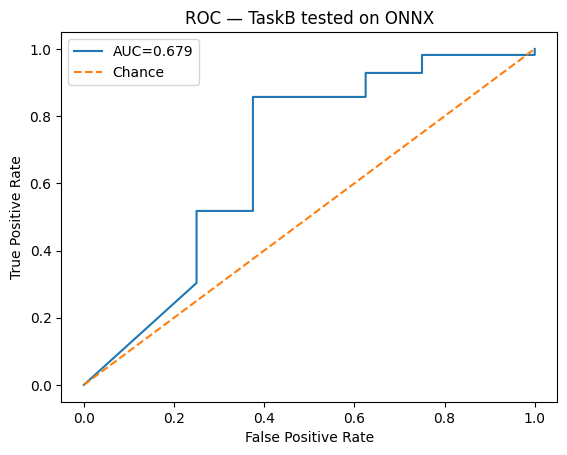

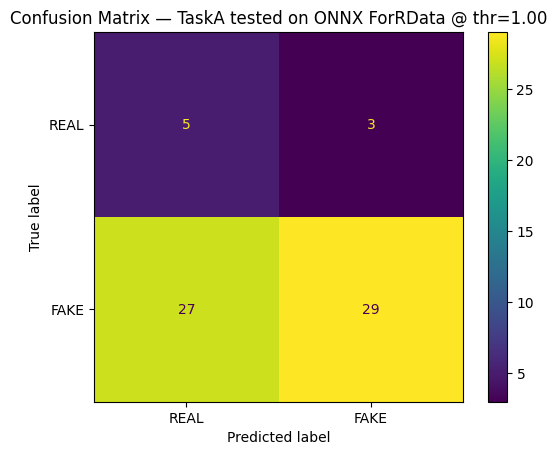

-rw-r--r-- 1 root root  274 Oct 29 14:43 TaskBTestedOnONNXForRData_report.json


In [125]:
assert os.path.exists(ONNX_PATH), f"ONNX not found at {ONNX_PATH}"
so = ort.SessionOptions()
so.intra_op_num_threads = 1
so.inter_op_num_threads = 1
sess = ort.InferenceSession(ONNX_PATH, sess_options=so, providers=["CPUExecutionProvider"])

RAW_NAME = "raw"; MEL_NAME = "mel"
inp_meta = {i.name: i.shape for i in sess.get_inputs()}
print("Input meta:", inp_meta)

def run_onnx_single(raw_np_1, mel_np_1):
    return sess.run(None, {RAW_NAME: raw_np_1.astype("float32"),
                           MEL_NAME: mel_np_1.astype("float32")})[0]  # (1,2)

scores = np.zeros(len(ext_paths), dtype=np.float32)  # P(fake)
preds  = np.zeros(len(ext_paths), dtype=np.int64)

n = 0
t0 = time.time()

for i, pth in enumerate(ext_paths):
    try:
        wav = load_resample_mono_crop1s(pth)
        raw, mel = wav_to_features_1s(wav)                 
        logits = run_onnx_single(raw.numpy(), mel.numpy()) 
        z = logits - logits.max(axis=1, keepdims=True)
        prob_fake = (np.exp(z) / (np.exp(z).sum(axis=1, keepdims=True)+1e-12))[0,1]
        scores[i] = prob_fake
        preds[i]  = int(prob_fake >= 0.5)
        n += 1
    except Exception:
        pass

dt = time.time() - t0
print(f"[ONNX External] Scored {n} samples in {dt:.2f}s ({1000.0*dt/max(1,n):.2f} ms/sample)")

# Save predictions CSV
out_rows = [["path", "p_fake", "pred", "label"]]
for i, pth in enumerate(ext_paths):
    lbl = "" if not have_lbls else int(labels_np[i])
    out_rows.append([pth, float(scores[i]), int(preds[i]), lbl])

with open("predictions_TaskBTestedOnONNX_ForRData.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(out_rows)

print("Saved: predictions_TaskBTestedOnONNXForRData.csv")

if have_lbls:
    # ROC-AUC / EER
    try:
        auc = roc_auc_score(labels_np, scores)
    except ValueError:
        auc = float("nan")
    fpr, tpr, thr = roc_curve(labels_np, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[idx] + fnr[idx])
    eer_thr = float(thr[idx])
    print(f"AUC = {auc:.4f}")
    print(f"EER = {eer:.4f} @ thr={eer_thr:.4f}")

    # ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],"--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC — TaskB tested on ONNX")
    plt.legend()
    plt.savefig("roc_TaskB tested on ONNXForRData.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Confusion matrix at EER threshold
    y_pred_eer = (scores >= eer_thr).astype(int)
    cm = confusion_matrix(labels_np, y_pred_eer, labels=[0,1])

    disp = ConfusionMatrixDisplay(cm, display_labels=["REAL","FAKE"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — TaskA tested on ONNX ForRData @ thr={eer_thr:.2f}")
    plt.savefig("cm_TaskB tested on ONNXForRData.png", dpi=200, bbox_inches="tight")
    plt.show()

    report = {
        "onnx_path": ONNX_PATH,
        "num_samples": int(len(ext_paths)),
        "auc": float(auc),
        "eer": float(eer),
        "eer_threshold": float(eer_thr),
        "confusion_matrix": cm.tolist()
    }
    with open("TaskBTestedOnONNXForRData_report.json", "w") as f:
        json.dump(report, f, indent=2)

    !ls -lh | egrep "predictions_TaskBTestedOnONNXForRData|roc_TaskBTestedOnONNXForRData|cm_TaskBTestedOnONNXForRData|TaskBTestedOnONNXForRData_report"
else:
    print("No labels detected — skipped ROC/CM. Only predictions_external.csv was created.")
    !ls -lh predictions_external.csv